# For plotting figures from processed data post-analysis

# Imports

In [1]:
import warnings
warnings.catch_warnings(record=True)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import logging
from polymerist.genutils.logutils.IOHandlers import LOG_FORMATTER
logging.basicConfig(
    level=logging.INFO,
    format =LOG_FORMATTER._fmt,
    datefmt=LOG_FORMATTER.datefmt,
    force=True
)
LOGGER = logging.getLogger(__name__)

from typing import Optional
from abc import ABC, abstractstaticmethod

from pathlib import Path
from ast import literal_eval

from math import ceil
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize, Colormap

from openff.toolkit import Molecule

from polymerist.genutils.fileutils.pathutils import assemble_path
from polymerist.genutils.maths.statistics import RMSE
from polymerist.genutils.maths.greek import GREEK_UPPER

from polymerist.graphics import plotutils
from polymerist.openfftools import topology

from polymerist.rdutils import rdprops
from polymerist.rdutils.labeling import molwise
from polymerist.rdutils.rdconvert import RDConverter
from polymerist.rdutils.rdkdraw import rdmol_prop_heatmap_colorscaled

# Defining Paths

## Simulation data

In [2]:
sim_data_dir = Path('wasp_sims')
mol_dirs = {
    path.stem : path
        for path in sim_data_dir.iterdir()
}

## Analyzed data

In [3]:
data_dir = Path('analysis_output/data/combined_data')
data_dir_props = data_dir / 'props'
data_dir_rdfs =  data_dir / 'rdfs'

## Plot output

In [4]:
figure_dir = Path('analysis_output/figures')
figure_dir.mkdir(exist_ok=True)

for subdir_name in ('rdfs', 'props', 'charges'):
    subdir = figure_dir / subdir_name
    subdir.mkdir(exist_ok=True)
    globals()[f'{figure_dir.name}_{subdir_name}'] = subdir # assign to variables in namespace

# Generating charged molecule graphics for RCT illustration

In [ ]:
from polymerist.genutils.fileutils.pathutils import assemble_path

mol_name = 'pnipam_modified'
charge_method = 'RCT'
struct_dir = Path('polymer_structures')

mol_dir = sim_data_dir / mol_name
sdf_path = assemble_path(mol_dir/charge_method, mol_name, postfix=charge_method, extension='sdf')
mono_path = assemble_path(struct_dir/'monomers', mol_name, extension='json')
rct_charges_path = assemble_path(mol_dir, mol_name, postfix='residue_charges', extension='json')

for path in (sdf_path, mono_path, rct_charges_path):
    print(path)
    assert(path.exists())

In [ ]:
from polymerist.monomers import MonomerGroup
from polymerist.openfftools import topology
from polymerist.residues.rescharge.rctypes import ChargesByResidue
from polymerist.rdutils import rdkdraw


# specify paths and parameters
chg_img_path = figures_charges / 'RCT_examples'
chg_img_path.mkdir(exist_ok=True)

offtop = topology.topology_from_sdf(sdf_path)
offmol = topology.get_largest_offmol(offtop)
cmap = plt.get_cmap('turbo')

# plot charge-colored structures
monogrp = MonomerGroup.from_file(mono_path)
lib_chgs = ChargesByResidue.from_file(rct_charges_path)
for resname, rdmol in monogrp.iter_rdmols():
    res_chgs = lib_chgs.charges[resname]
    for atom in rdmol.GetAtoms():
        if atom.GetAtomMapNum() in res_chgs:
            atom.SetDoubleProp('PartialCharge', res_chgs[atom.GetAtomMapNum()])
        else:
            atom.SetDoubleProp('PartialCharge', 0)

    mono_img_path = assemble_path(chg_img_path, mol_name, postfix=f'monomer_{resname}', extension='png')
    mono_img = rdkdraw.rdmol_prop_heatmap(rdmol, 'PartialCharge', cmap=cmap)
    mono_img.save(mono_img_path)

mol_img_path = assemble_path(chg_img_path, mol_name, extension='png')
mol_img = rdkdraw.rdmol_prop_heatmap(offmol.to_rdkit(), 'PartialCharge', cmap=cmap)
mol_img.save(mol_img_path)

# Shape properties

In [ ]:
# defining colors for MD framework (sampled from tab20)
color_set = (
    'blue',
    'orange',
    'green',
    'purple',
    'grey',
)
hues_per_color = 4
cmap = plt.get_cmap('tab20c')

cdict, carr = plotutils.label_discrete_cmap(cmap, color_set, hues_per_color)
dset_colors = {
    'Sage 2.0.0 - RCT'              : cdict['blue0'  ],
    'Sage 2.0.0 - Espaloma-AM1-BCC' : cdict['blue2'  ],
    'DREIDING - RESP'               : cdict['purple0'],
    'CHARMM - Mulliken'             : cdict['orange0'],
    'CHARMM-c - Mulliken'           : cdict['orange2'],
    'GAFF - RESP'                   : cdict['green0' ],
    'GAFF2 - RESP'                  : cdict['green2' ],
}

for prop_data_path in data_dir_props.iterdir():
    mol_name = prop_data_path.stem
    dframe = pd.read_csv(prop_data_path, index_col=[0, 1])
    dframe = dframe.sort_index(axis=1, key=lambda x : [list(dset_colors.keys()).index(c) for c in x]) # sort in same order as colors are defined
    obs = dframe.loc['observables']
    std = dframe.loc['uncertainties']

    frameworks = obs.columns
    num_dsets = len(frameworks)
    num_props = len(obs.index)
    x_pos = np.arange(num_dsets)

    fig, ax = plotutils.presize_subplots(nrows=1, ncols=num_props)
    # fig.suptitle(mol_name)

    for axis, (prop_name, prop_data) in zip(ax.flatten(), obs.iterrows()):
        uncert = std.loc[prop_name].to_numpy()


        axis.set_title(prop_name)
        axis.bar(x_pos, prop_data, yerr=uncert, color=[dset_colors[fr] for fr in frameworks])
        axis.set_xticks(x_pos)
        axis.set_xticklabels([fw.replace(' - ', '\n + ').replace('Espaloma-AM1-BCC', 'Espaloma') for fw in obs.columns], rotation=-40)

    fig.savefig(figures_props / f'{mol_name}_properties.png', bbox_inches='tight')
    plt.close()

# RDFs

In [ ]:
# set plotting parameters
fontsize = 14
scale = 10
aspect = 4/5

# subrange_min = 0.0 # subrange cutoffs, in nm
# subrange_max = 0.5
subrange_min = 0.2 # subrange cutoffs, in nm
subrange_max = 1.2

inset_head_fract : float = 1.2 # fraction of the width of the RDF plot to add to the top to accomodate the inset
inset_perc_x = 40 # percentage of main figure size to scale inset x axis
inset_perc_y = 40 # percentage of main figure size to scale inset y axis

# radii from new data
radii_label = 'Radius (nanometer)'

# loop over and plot
for data_path_rdf in data_dir_rdfs.iterdir():
    mol_name = data_path_rdf.stem
    combined_rdf_dframe = pd.read_csv(data_path_rdf, index_col=[0, 1])
    combined_rdf_dframe = combined_rdf_dframe.sort_index(axis=1, key=lambda x : [list(dset_colors.keys()).index(c) for c in x]) # sort in same order as colors are defined

    rdf_labels, series_names = combined_rdf_dframe.index.levels
    for rdf_name in rdf_labels:
        subframe = combined_rdf_dframe.xs(rdf_name)
        subframe = subframe.dropna(axis=1, inplace=False) # remove missing columns
        subframe = subframe.map(literal_eval) # de-stringify lists throughout

        fig, ax = plotutils.presize_subplots(nrows=1, ncols=1, scale=scale, elongation=aspect)
        # fig.suptitle(mol_name)

        ax.set_xlabel(radii_label, fontsize=fontsize)
        ax.set_ylabel(rdf_name, fontsize=fontsize)
        ax.set_xlim(subrange_min, subrange_max)

        inset_ax = inset_axes(ax, # generate longer length-scale inset
            width =f'{inset_perc_x}%',
            height=f'{inset_perc_y}%',
            borderpad=3,
            loc='upper right'
        )
        inset_ax.set_xlabel(radii_label, fontsize=fontsize)

        for framework, data in subframe.items():
            radii, rdf_mean, rdf_std = [
                np.array(data[ser_name])
                    for ser_name in series_names
            ]
            subrange_idxs = np.where((subrange_min < radii) & (radii < subrange_max)) # extract region corresponding to 2-12 angstroms shown by Rukmani
            err_lower = rdf_mean - rdf_std # compute error band boundaries
            err_upper = rdf_mean + rdf_std

            # extract subranges
            radii_subrange    = radii[   subrange_idxs]
            rdf_mean_subrange = rdf_mean[subrange_idxs]
            rdf_std_subrange  = rdf_std[ subrange_idxs]
            
            err_lower_subrange  = err_lower[subrange_idxs]
            err_upper_subrange  = err_upper[subrange_idxs]
            ax.set_ylim(0, err_upper_subrange.max() * (1 + inset_head_fract)) # accomodate inset with maximum error
            
            # plot reduced main plot
            ax.plot(radii_subrange, rdf_mean_subrange, label=framework)
            ax.fill_between(radii_subrange, rdf_mean_subrange - rdf_std_subrange, rdf_mean_subrange + rdf_std_subrange, alpha=0.5)

            # plot longer length-scale inset
            inset_ax.plot(radii, rdf_mean, label=framework)
            inset_ax.fill_between(radii, rdf_mean - rdf_std, rdf_mean + rdf_std, alpha=0.5)
            
        ax.legend(loc='lower right', fontsize=fontsize)
        fig.savefig(figures_rdfs / f'{mol_name}_{rdf_name}.png', bbox_inches='tight')
        plt.close()

# Comparing charges

## Define methods for automatically determining number of histogram bins

In [5]:
class BinSizer(ABC):
    '''Abstract base for auto-sizing histogram bins
    Child class implementations taken from https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width'''
    @abstractstaticmethod
    def num_bins(N : int) -> int:
        raise NotImplementedError

    @classmethod
    @property
    def registry(cls) -> dict[str, 'BinSizer']:
        '''Name-indexed dict of all inherited Component implementations'''
        return {
            subcomp.__name__ : subcomp
                for subcomp in cls.__subclasses__()
        }

class Sturges(BinSizer):
    '''Based on Sturges' Formula'''
    @staticmethod
    def num_bins(N: int) -> int:
        return 1 + ceil(np.log2(N)) 

class Sqrt(BinSizer):
    '''Based on square root'''
    @staticmethod
    def num_bins(N: int) -> int:
        return ceil(np.sqrt(N))

class Rice(BinSizer):
    '''Based on Rice's Rule'''
    @staticmethod
    def num_bins(N: int) -> int:
        return ceil(2 * N**(1/3))

## Affine transformation matrices for shifting RDMkit molecules to fit plots

In [6]:
def xyzTrans(x : float, y : float, z : float) -> np.ndarray:
    return np.array([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1],
    ], dtype='float64')

def xRot(theta : float) -> np.ndarray:
    s = np.sin(theta)
    c = np.cos(theta)
    
    return np.array([
        [1, 0,  0, 0],
        [0, c, -s, 0],
        [0, s,  c, 0],
        [0, 0,  0, 1],
    ], dtype='float64')

def yRot(theta : float) -> np.ndarray:
    s = np.sin(theta)
    c = np.cos(theta)
    
    return np.array([
        [c, 0, -s, 0],
        [0, 1,  0, 0],
        [s, 0,  c, 0],
        [0, 0,  0, 1],
    ], dtype='float64')

def zRot(theta : float) -> np.ndarray:
    s = np.sin(theta)
    c = np.cos(theta)
    
    return np.array([
        [c, -s, 0, 0],
        [s,  c, 0, 0],
        [0,  0, 1, 0],
        [0,  0, 0, 1],
    ], dtype='float64')

## Unified plotting methods

In [7]:
from rdkit.Chem import rdMolTransforms

def generate_charge_plots(cmols : dict[str, Molecule], cmap : Colormap, n_bins : int=50, fontsize : int=14, aspect : float=4/5, norm : Optional[Normalize]=None, ticks : Optional[tuple[float]]=None,
                          cvtr : Optional[RDConverter]=None, transform : Optional[np.ndarray]=None) -> tuple[tuple[plt.Figure, plt.Axes], tuple[plt.Figure, plt.Axes]]:
    '''Create charge difference heatmaps and histograms for a pair of parameterized Molecules'''
    # 0a) extract molecules
    chgd_offmol_1, chgd_offmol_2 = cmols.values()
    rdmols = [
        molwise.assign_ordered_atom_map_nums(offmol.to_rdkit(), in_place=False)
            for offmol in cmols.values()
    ]

    ## 0a) create string labels
    method_str = ' vs '.join(cmols)
    chg_delta_str = f'{GREEK_UPPER["delta"]}q (elem. charge)'
    # diff_str = f'{chg_delta_str} : {method_str}'
    diff_str = f'{chg_delta_str} \n {method_str}'

    # 1) generate heatmap
    diffmol = rdprops.difference_rdmol(*rdmols, prop='PartialCharge')
    newprop = f'DeltaPartialCharge'
    if cvtr is not None:
        diffmol = cvtr.convert(diffmol)

    if transform is not None:
        rdMolTransforms.CanonicalizeMol(   diffmol) # align principal axes to x, y, z axes
        rdMolTransforms.TransformConformer(diffmol.GetConformer(0), transform) # apply affine transformation

    # generate norm for colorscale
    deltas = rdprops.aggregate_atom_prop(diffmol, prop=newprop, prop_type=float)
    # deltas = literal_eval(diffmol.GetProp('DeltaPartialCharges'))
    deltas = np.array([i for i in deltas.values()])

    if norm is None:
        norm, ticks = rdkdraw.tight_norm_for_rdmol_prop(diffmol, prop=newprop, prop_type=float)

    # generating heatmap
    # hm_fig, hm_ax = rdmol_prop_heatmap_colorscaled(diffmol, prop=newprop, cmap=cmap, cbar_label=diff_str, orient='vertical')
    hm_fig, hm_ax = rdmol_prop_heatmap_colorscaled(diffmol, prop=newprop, cmap=cmap, norm=norm, ticks=ticks, cbar_label='', orient='vertical')

    # generating histogram
    hist_fig, hist_ax = plotutils.presize_subplots(1, 1, scale=8, elongation=aspect)
    bin_vals, bin_edges, patches = hist_ax.hist(deltas, bins=n_bins, orientation='horizontal')

    # coloring histogram bars by atom color map
    for bin_edge, artist in zip(bin_edges, patches):
        plt.setp(artist, 'facecolor', cmap(norm(bin_edge)))

    # computing and labelling charge rmse
    rmse = RMSE(chgd_offmol_1.partial_charges, chgd_offmol_2.partial_charges)
    labels = [f'RMSE = {round(rmse.magnitude, 5)} e']
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * len(labels) # create empty handles to pin annotation text to
    hist_ax.legend(handles, labels, loc='best', handlelength=0, fontsize=fontsize)
    # hist_ax.annotate(f'rmse = {round(rmse.magnitude, 5)} e', (0.65, 0.9), xycoords='axes fraction', fontsize=14, bbox=dict(edgecolor='black', facecolor='white'))

    # Labelling and sizing axes
    # hist_ax.set_title(f'{polymer.mol_name} charge differences')
    _ = hist_ax.set_yticks(ticks)
    hist_ax.set_xlabel('Number of atoms', fontsize=fontsize)
    hist_ax.set_ylabel(diff_str, fontsize=fontsize)

    return ((hm_fig, hm_ax), (hist_fig, hist_ax))

2023-12-19 13:39:42.672 [INFO    :        topology:line 96  ] - Loading serialized SDF Topology from wasp_sims/paam_modified/paam_modified_reduced_RCT.sdf
2023-12-19 13:39:42.717 [INFO    :        topology:line 96  ] - Loading serialized SDF Topology from wasp_sims/paam_modified/paam_modified_reduced_AM1-BCC-ELF10.sdf


2023-12-19 13:39:42.748 [INFO    :        topology:line 96  ] - Loading serialized SDF Topology from wasp_sims/paam_modified/RCT/paam_modified_RCT.sdf
2023-12-19 13:39:42.854 [INFO    :        topology:line 96  ] - Loading serialized SDF Topology from wasp_sims/paam_modified/Espaloma-AM1-BCC/paam_modified_Espaloma-AM1-BCC.sdf
2023-12-19 13:39:44.387 [INFO    :        topology:line 96  ] - Loading serialized SDF Topology from wasp_sims/pnipam_modified/pnipam_modified_reduced_RCT.sdf
2023-12-19 13:39:44.408 [INFO    :        topology:line 96  ] - Loading serialized SDF Topology from wasp_sims/pnipam_modified/pnipam_modified_reduced_AM1-BCC-ELF10.sdf
2023-12-19 13:39:44.427 [INFO    :        topology:line 96  ] - Loading serialized SDF Topology from wasp_sims/pnipam_modified/RCT/pnipam_modified_RCT.sdf
2023-12-19 13:39:44.528 [INFO    :        topology:line 96  ] - Loading serialized SDF Topology from wasp_sims/pnipam_modified/Espaloma-AM1-BCC/pnipam_modified_Espaloma-AM1-BCC.sdf
2023-12-

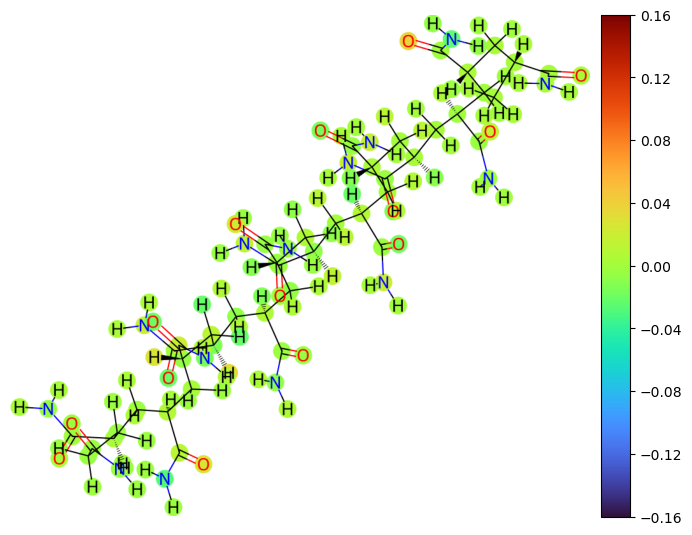

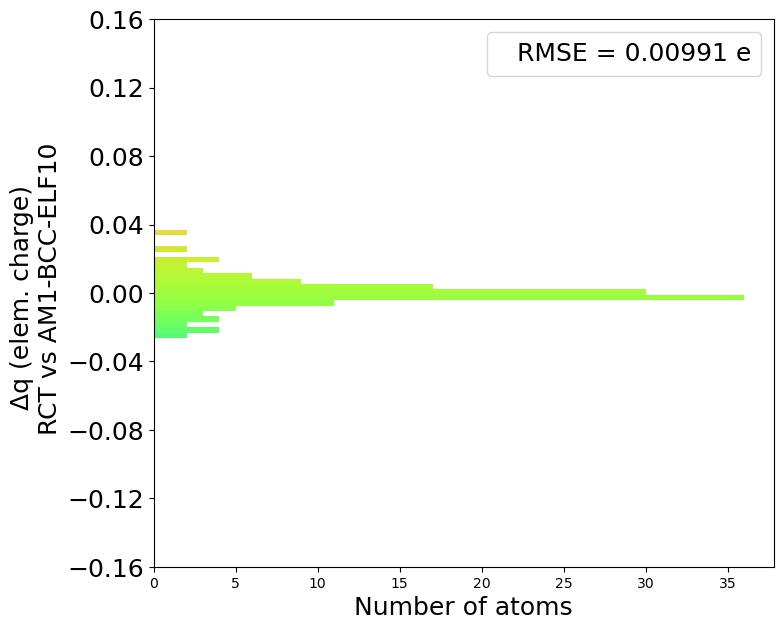

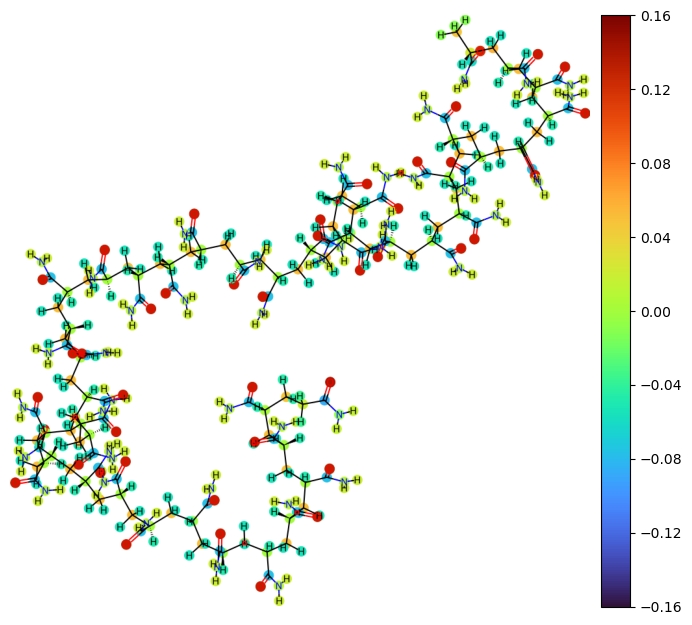

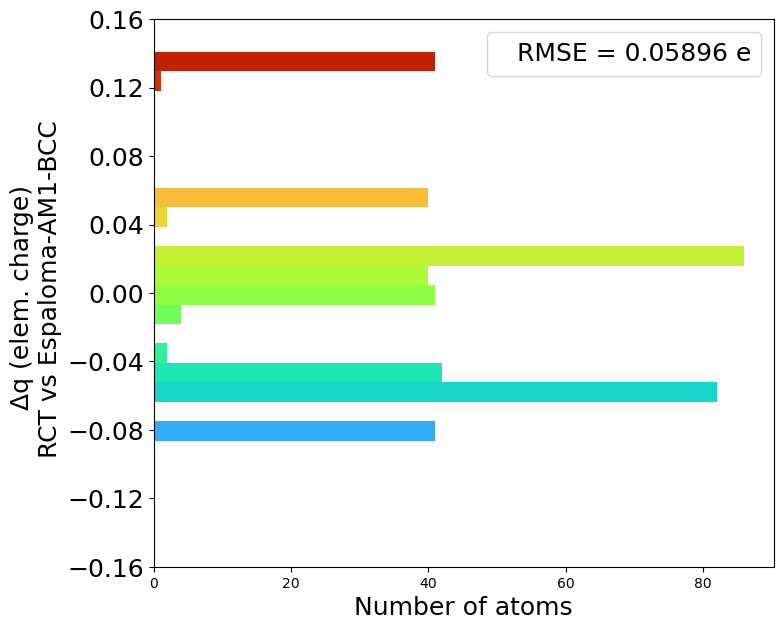

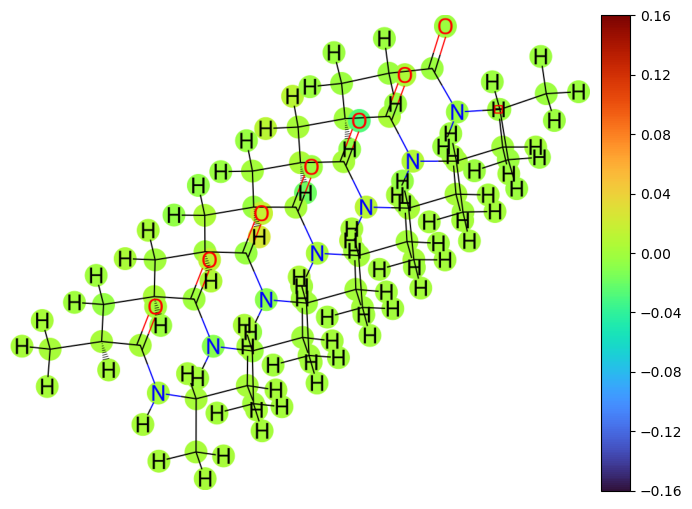

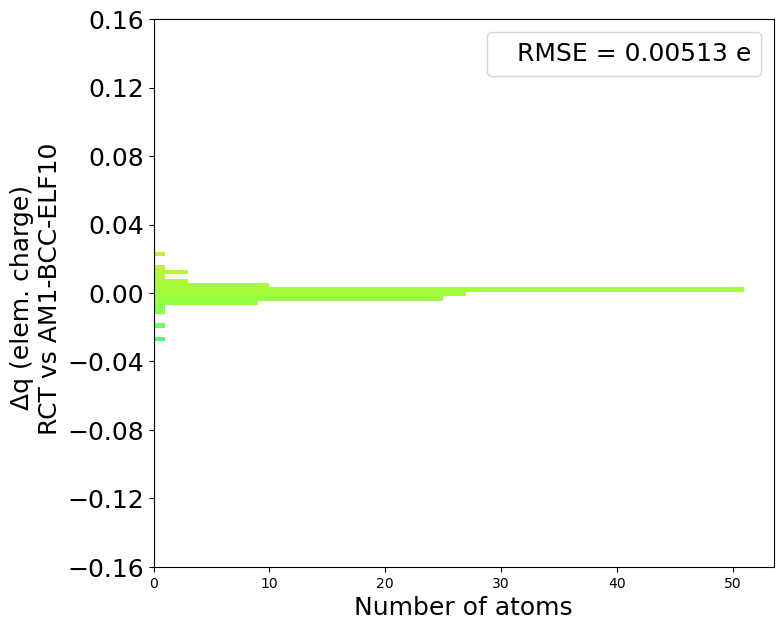

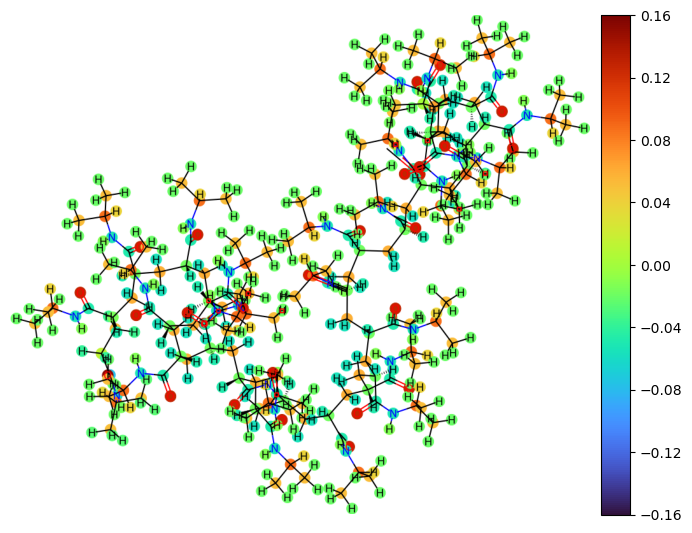

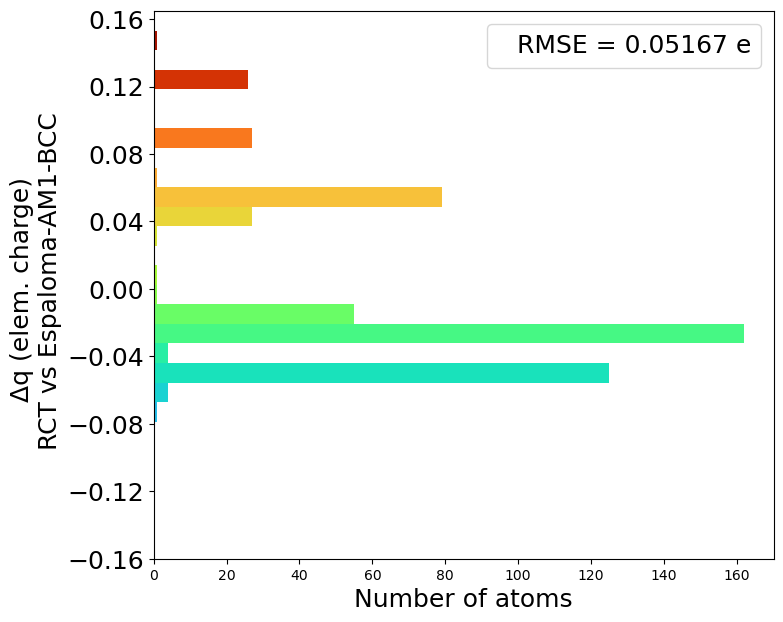

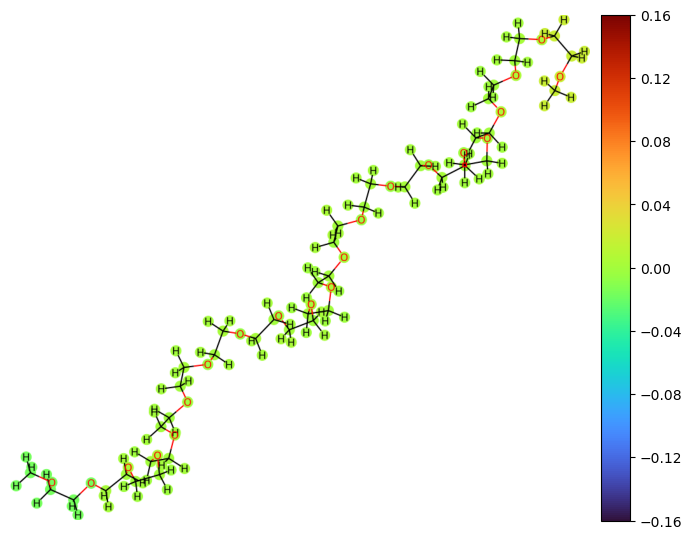

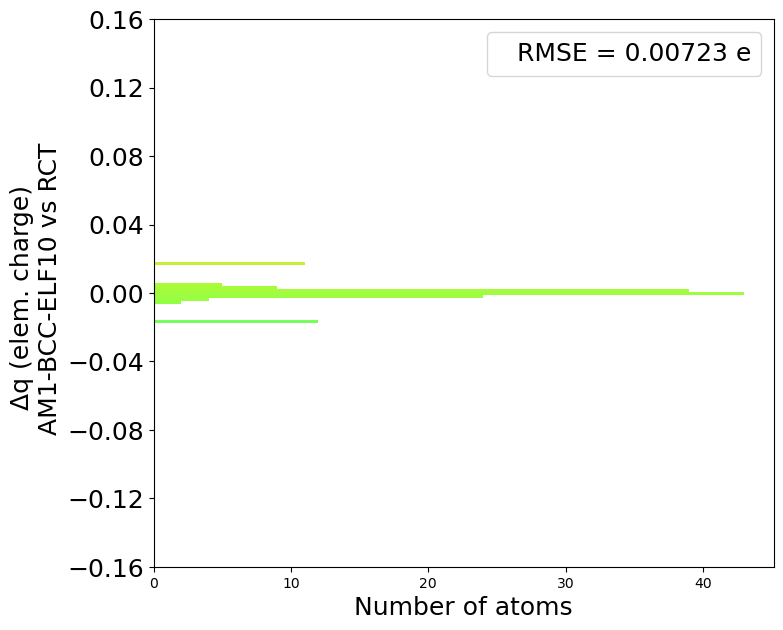

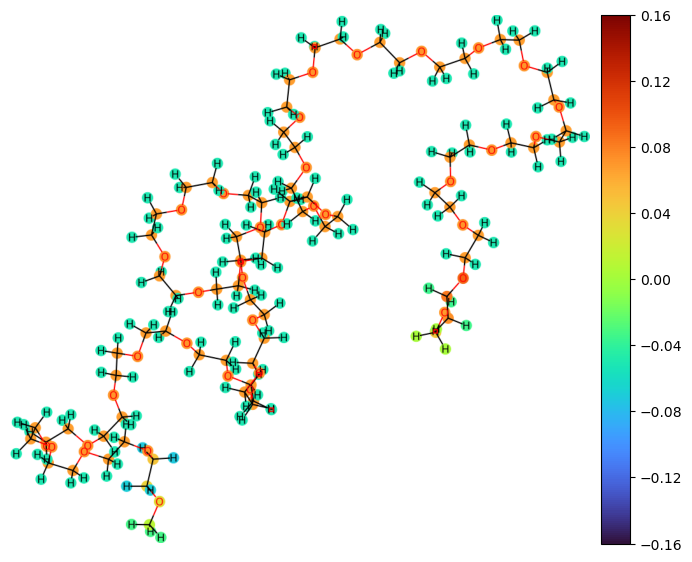

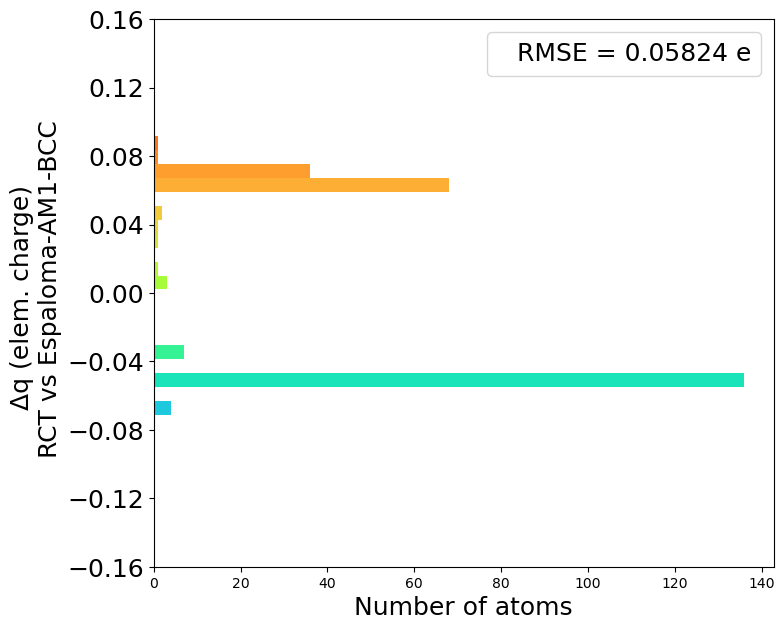

In [12]:
from functools import reduce
from collections import defaultdict

from polymerist.rdutils import rdkdraw
rdkdraw.set_rdkdraw_size(300, 3/2)
TAU = 2*np.pi


# plotting parameters
fontsize : int   = 18
n_bins   : int   = 20
aspect   : float = 8/9
asp_corr : float = 1.5

vmax, vmin = 0.16, -0.16
ndiv = 8
rotations = np.array([np.arctan(aspect * asp_corr), 0, -1/8*TAU]) # angles about x, y, and, z axes to rotate molecules; force in-page rotation to align across diagonal
# rotations = np.array([TAU/6, 0, 0]) # angles about x, y, and, z axes to rotate molecules; force in-page rotation to align across diagonal
# rotations = np.array([0, 1*TAU/4, 0]) # angles about x, y, and, z axes to rotate molecules; force in-page rotation to align across diagonal
# rotations = np.array([0, 0, TAU/4]) # angles about x, y, and, z axes to rotate molecules; force in-page rotation to align across diagonal

# plotting pre-processing
norm = Normalize(vmin=vmin, vmax=vmax)
ticks = np.linspace(vmin, vmax, num=ndiv + 1)
transform = reduce(np.matmul, (rotfun(angle) for angle, rotfun in zip(rotations[::-1], (xRot, yRot, zRot)))) # reverse order to perform z-rotation first

# plotting execution
all_mols = {}
mol_sizes : dict[str, int ] = {}
for mol_name, mol_dir in mol_dirs.items():
    mol_dir_chg = figures_charges / mol_name
    mol_dir_chg.mkdir(exist_ok=True)

    cmols = defaultdict(defaultdict)

    # plot charges on reductions
    for path in mol_dir.iterdir():
        if (path.suffix == '.sdf') and ('reduced' in path.name):
            charge_method = path.stem.split('_')[-1]
            cmol = topology.get_largest_offmol(topology.topology_from_sdf(path))
            mol_sizes[('reduced', cmol.name)] = cmol.n_atoms # record chain length 
            cmols['redux'][charge_method] = cmol

    # plot charges on full molecules
    for charge_method in ('RCT', 'Espaloma-AM1-BCC'):
        full_sdf_path = assemble_path(mol_dir / charge_method, f'{mol_name}_{charge_method}', extension='sdf')
        cmol = topology.get_largest_offmol(topology.topology_from_sdf(full_sdf_path))
        mol_sizes[('full', cmol.name)] = cmol.n_atoms # record chain length 
        cmols['full'][charge_method] = cmol

    ## obtain heatmaps and histograms for reductions
    for suffix, cmol_dict in cmols.items():
        (heatmap_fig, heatmap_ax), (histogram_fig, histogram_ax) = generate_charge_plots(
            cmol_dict,
            cmap=plt.get_cmap('turbo'),
            n_bins=n_bins,
            fontsize=fontsize,
            aspect=aspect,
            norm=norm,
            ticks=ticks,
            transform=transform
        )

        ## post-adjust y-axis tick label size
        histogram_ax.tick_params(axis='y', labelsize=fontsize)
        heatmap_ax.tick_params(  axis='y', labelsize=fontsize)
        heatmap_fig.savefig(  mol_dir_chg / f'{mol_name}_{suffix}_heatmap.png', bbox_inches='tight')
        histogram_fig.savefig(mol_dir_chg / f'{mol_name}_{suffix}_histogram.png', bbox_inches='tight')
        # plt.close()

# record chain lengths
chain_df = pd.DataFrame.from_dict({'Chain length (N)' : mol_sizes})
chain_path = data_dir / 'chain_sizes.csv'
chain_df.to_csv(chain_path)